In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.transforms as mtrans
import seaborn as sns

from utils.data import get_hsm_dataset, get_solar_energy_dataset, get_fuel_prices_dataset, get_passengers_dataset, log_returns, inverse_log_returns, get_dataset_iterator
from utils.visualization import visualization

In [2]:
hsm_dataset_dir = Path("data/huge_stock_market_dataset/")
se_dataset_dir = Path("data/solar_energy/")
fp_dataset_dir = Path("data/fuel_prices/")
ap_dataset_dir = Path("data/air_passengers/")
results_dir = Path("results")

In [3]:
# def is_high_volatile(time_series, threshold=0.5, rolling_parts=200):
#     orig_std = time_series.std().values[0]
#     ma_ts = time_series.rolling(len(time_series) // rolling_parts).mean()
#     ma_std = ma_ts.std().values[0]
#     return abs(ma_std - orig_std) / orig_std# > threshold

# def ma(time_series, rolling_parts=200):
#     ts1 = time_series.rolling(len(time_series) // rolling_parts, closed="left").mean()
#     ts2 = time_series[:: - 1].rolling(len(time_series) // rolling_parts).mean()[:: - 1]
#     ts1[ts1.isna()] = ts2[ts1.isna()]
#     ts2[ts2.isna()] = ts1[ts2.isna()]
#     ats = (ts1 + ts2) / 2
#     return ats
    
# for ts in get_passengers_dataset(ap_dataset_dir):
#     print(is_high_volatile(ts, rolling_parts=200))

In [4]:
results = []
for results_type in ("real", "QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
    for model in ("LSTM", "TCN"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if results_type == "real":
                df = pd.read_csv(results_dir / f"{results_type}_{dataset_name}_{model}.csv")
            else:
                df = pd.read_csv(results_dir / f"synth_{results_type}_{dataset_name}_{model}.csv")
            df["model"] = model
            df["results_type"] = results_type
            df["dataset"] = dataset_name
            results.append(df)
results = pd.concat(results)
results

,test,model,results_type,dataset
0,0.352968,LSTM,real,hsm
1,0.168099,LSTM,real,hsm
2,1.425858,LSTM,real,hsm
3,0.139445,LSTM,real,hsm
4,0.283939,LSTM,real,hsm
...,...,...,...,...
45,0.554096,TCN,TimeDiffusion,ap
46,0.913093,TCN,TimeDiffusion,ap
47,1.294599,TCN,TimeDiffusion,ap
48,1.995420,TCN,TimeDiffusion,ap


In [5]:
results_agg = results.groupby(by=["model", "results_type", "dataset"], axis=0, as_index=False).agg(test=("test", "mean"))
results_agg

,model,results_type,dataset,test
0,LSTM,FourierFlow,ap,0.916432
1,LSTM,FourierFlow,fp,0.384317
2,LSTM,FourierFlow,hsm,0.437786
3,LSTM,FourierFlow,se,0.257601
4,LSTM,QuantGAN,ap,0.863638
5,LSTM,QuantGAN,fp,0.910415
6,LSTM,QuantGAN,hsm,0.875300
7,LSTM,QuantGAN,se,0.641228
8,LSTM,RealNVP,ap,6.138466
9,LSTM,RealNVP,fp,0.624790


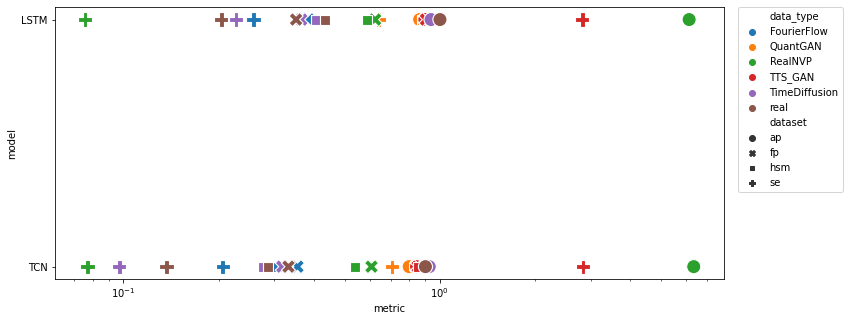

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(x=results_agg["test"].rename("metric"), y=results_agg["model"], 
    hue=results_agg["results_type"].rename("data_type"), style=results_agg["dataset"], s=200, ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xscale("log")
plt.show()

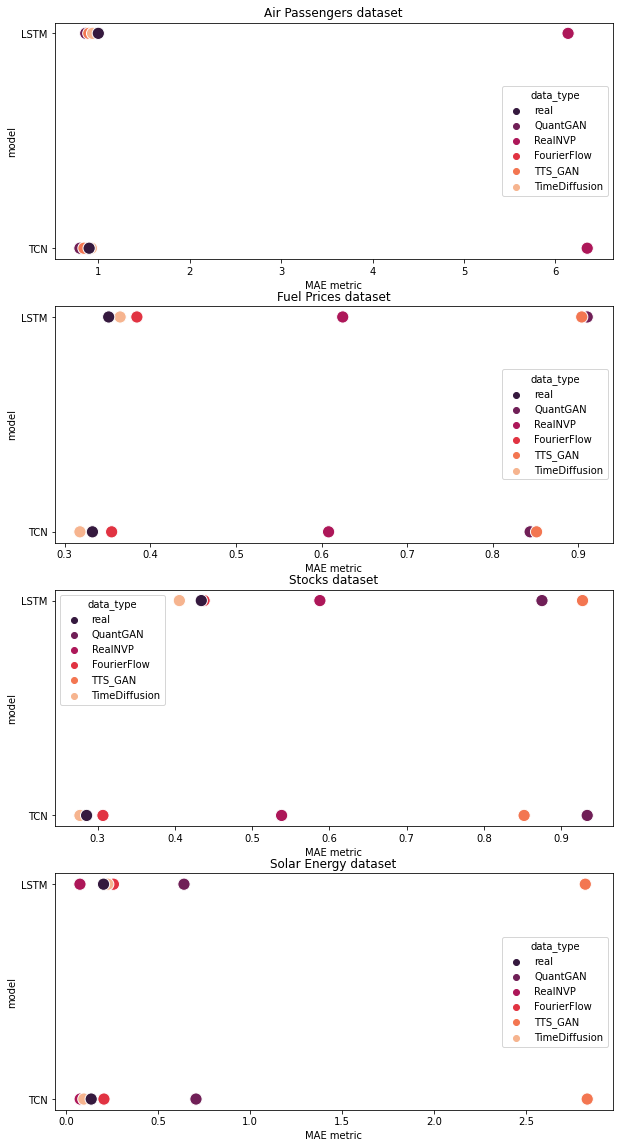

In [7]:
fig, axs = plt.subplots(4, figsize=(10, 20))
for i, dataset_name in enumerate(results_agg.dataset.unique()):
    loc_res = results_agg[results_agg.dataset == dataset_name]
    sns.scatterplot(x=loc_res["test"].rename("MAE metric"), y=loc_res["model"], hue=loc_res["results_type"].rename("data_type"),
     hue_order=("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion"), ax=axs[i], s=150, palette="rocket")
    axs[i].set_title({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}[dataset_name] + " dataset")

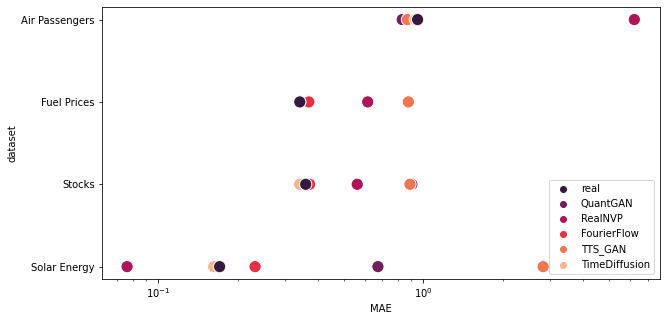

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
advanced_results_agg = results_agg.groupby(["dataset", "results_type"], as_index=False).agg(MAE=("test", "mean"))
sns.scatterplot(data=advanced_results_agg, x="MAE", y=advanced_results_agg["dataset"]\
    .replace({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}),\
    hue="results_type",\
    hue_order=("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion"), ax=ax, s=150, palette="rocket")
ax.legend(bbox_to_anchor=(0.99, 0.02), loc='lower right', borderaxespad=0)
plt.xscale("log")
plt.show()

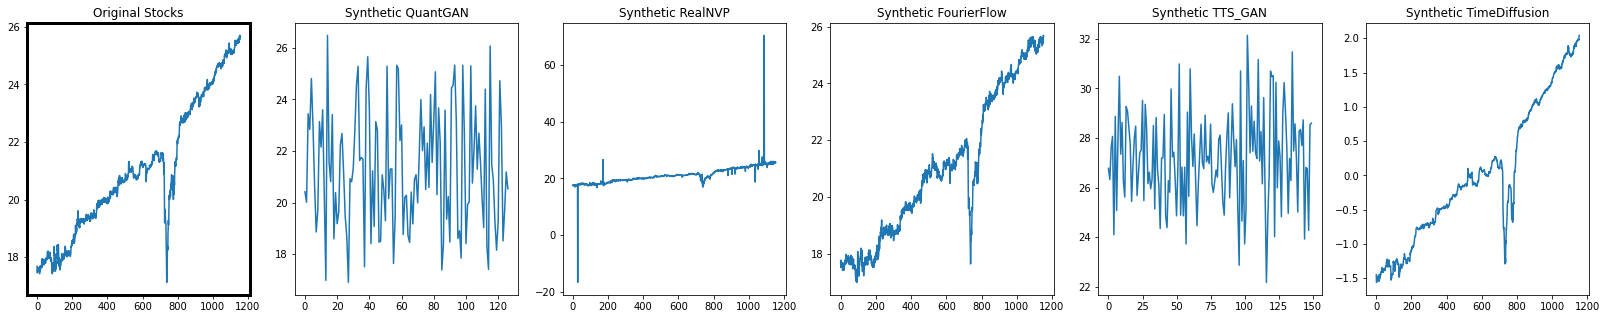

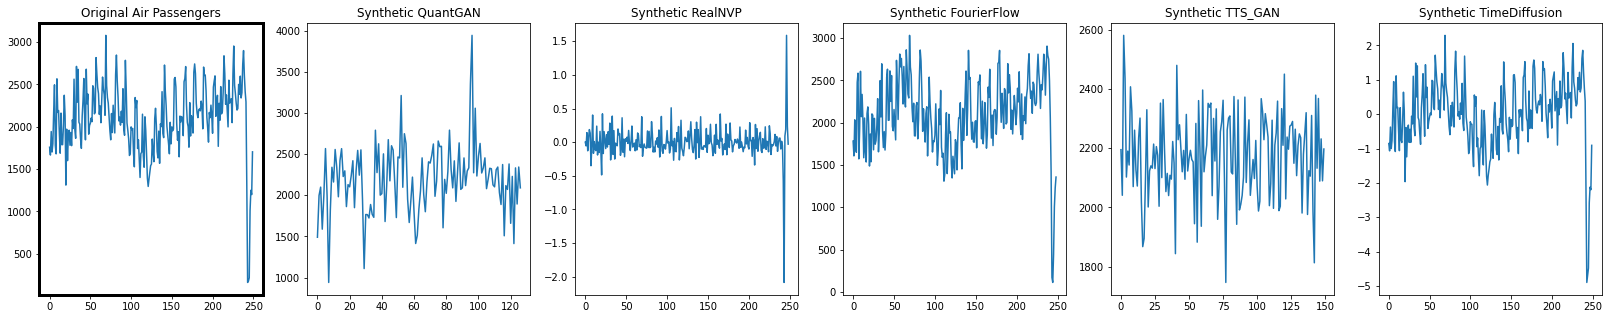

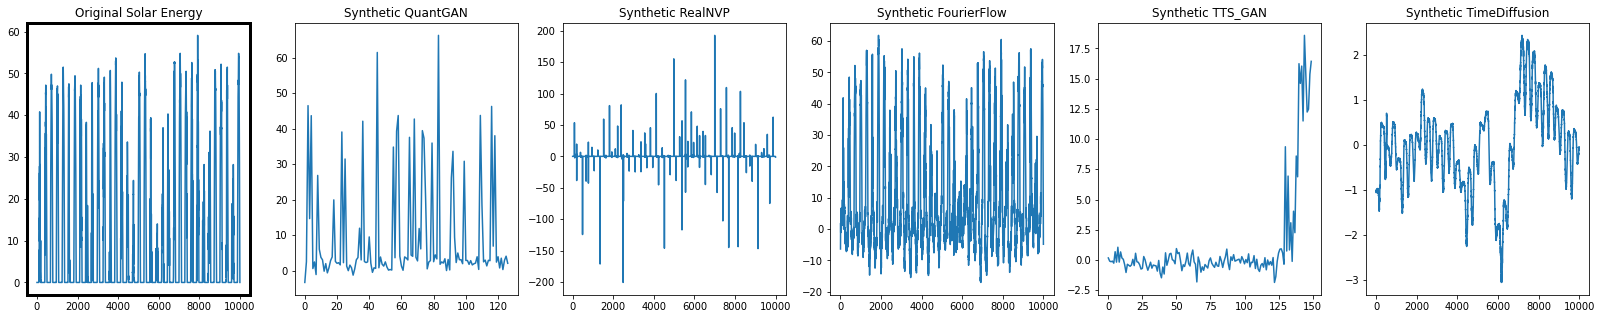

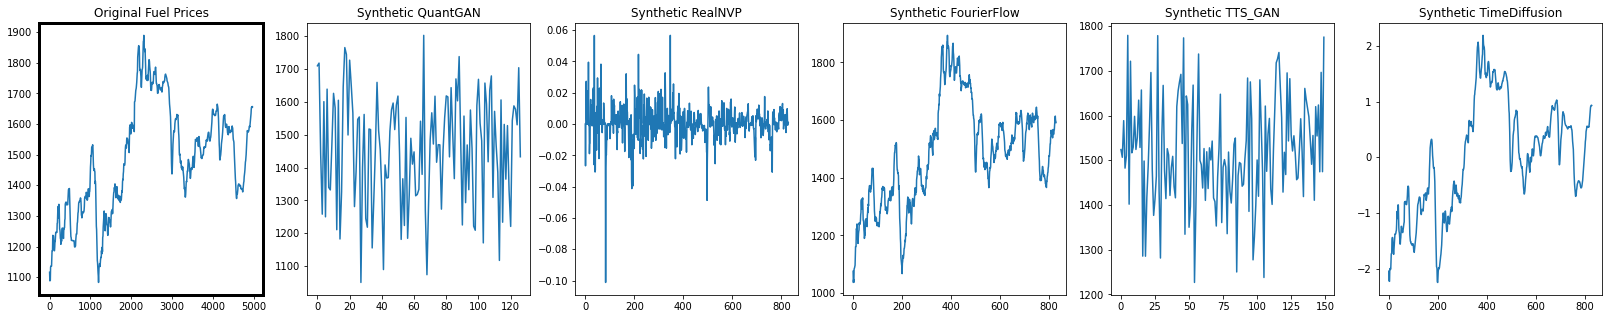

In [9]:
for dataset_name, dataset_dir, dataset_func in (
    ("Stocks", hsm_dataset_dir, get_hsm_dataset),
    ("Air Passengers", ap_dataset_dir, get_passengers_dataset),
    ("Solar Energy", se_dataset_dir, get_solar_energy_dataset),
    ("Fuel Prices", fp_dataset_dir, get_fuel_prices_dataset),   
):
    if dataset_name == "Stocks":
        time_series = next(dataset_func(dataset_dir, dataset_dir / "selected100.csv"))
    else:
        time_series = next(dataset_func(dataset_dir))

    fig, axs = plt.subplots(1, 6, figsize=(28, 5))
    axs[0].plot(time_series)
    axs[0].set_title(f"Original {dataset_name}")
    for i in axs[0].spines.values():
        i.set_linewidth(3)
    # axs[0].get_xaxis().set_visible(False)
    # axs[0].get_yaxis().set_visible(False)
    for i, model_name in zip(range(1, 6), ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion")):
        synth_time_series = np.load(dataset_dir / f"synthetic/{model_name}/selected0.npy")
        axs[i].plot(synth_time_series[- 1].flatten())
        axs[i].set_title(f"Synthetic {model_name}")
        # axs[i].get_xaxis().set_visible(False)
        # axs[i].get_yaxis().set_visible(False)
# fig.tight_layout()
# for y in np.arange(0, 6, 1):
#     fig.add_artist(plt.Line2D([1/6, 1/6], [y, y + 1], transform=fig.transFigure, color="black"))
plt.show()

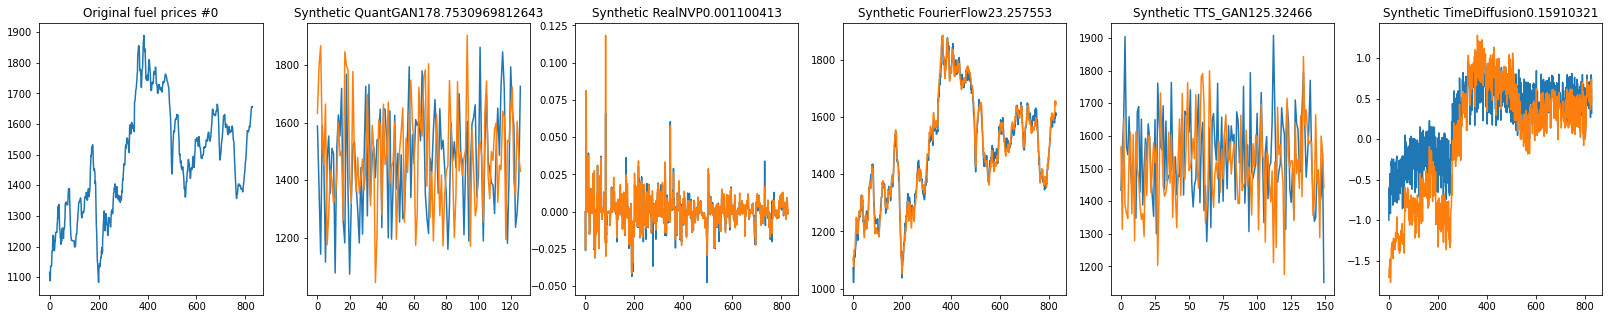

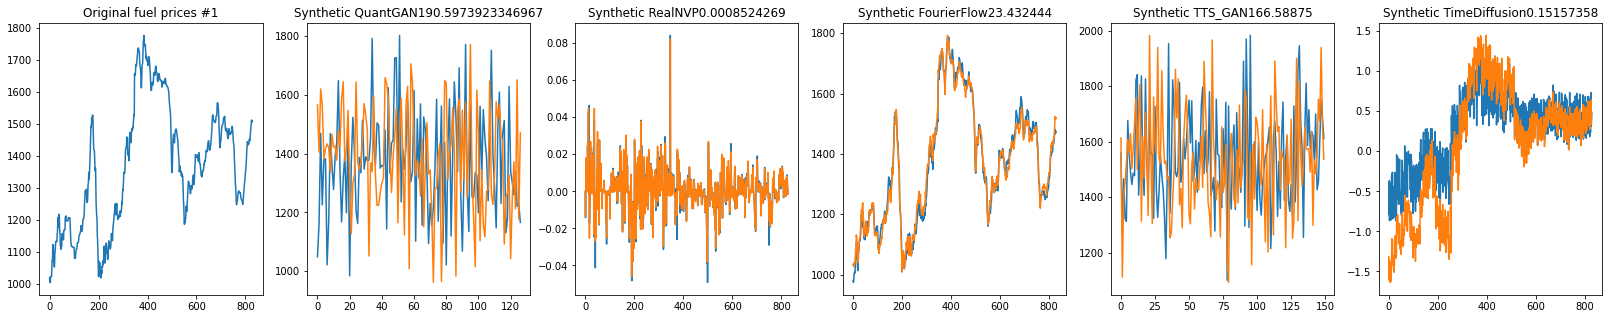

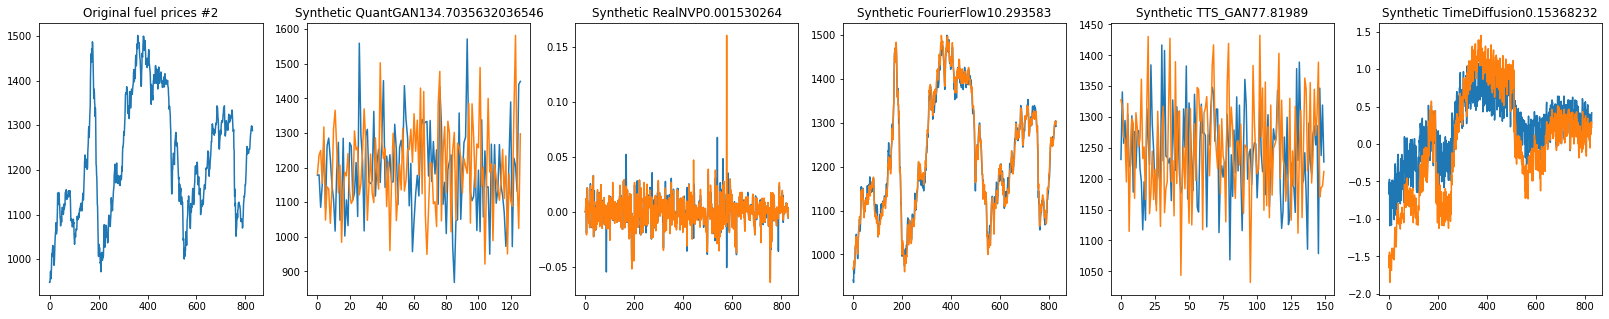

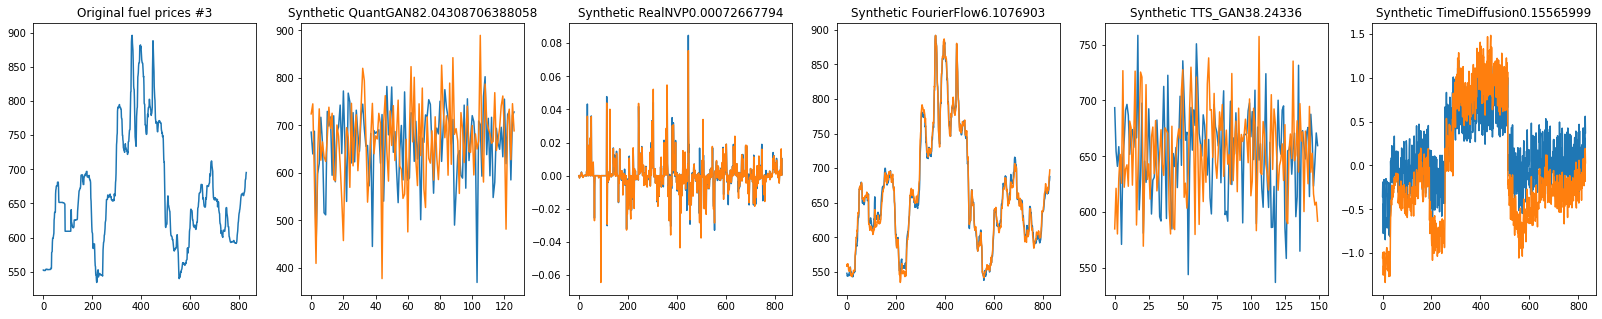

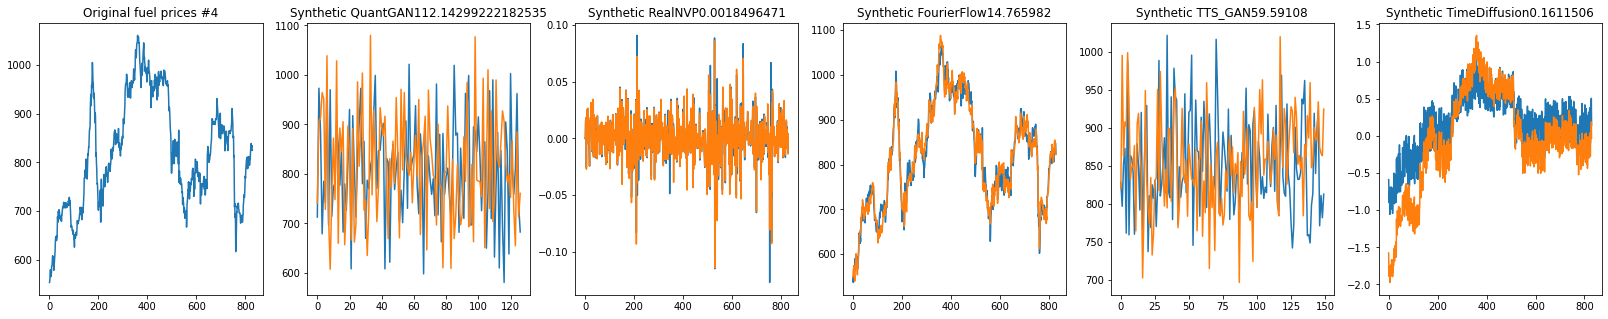

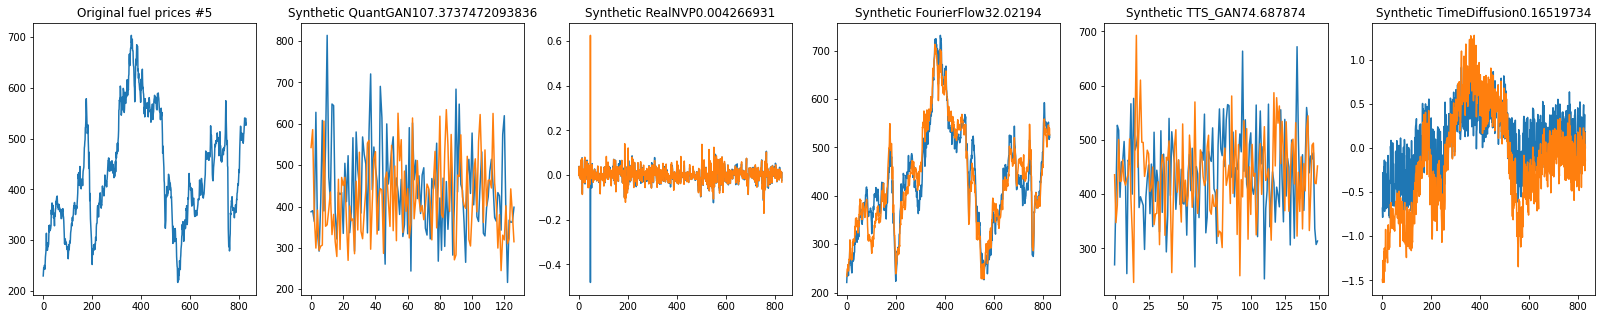

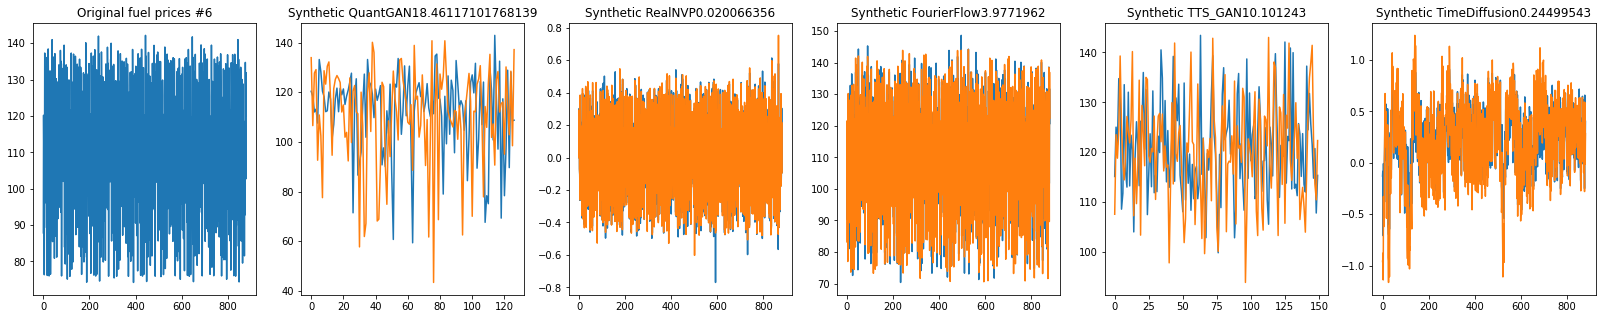

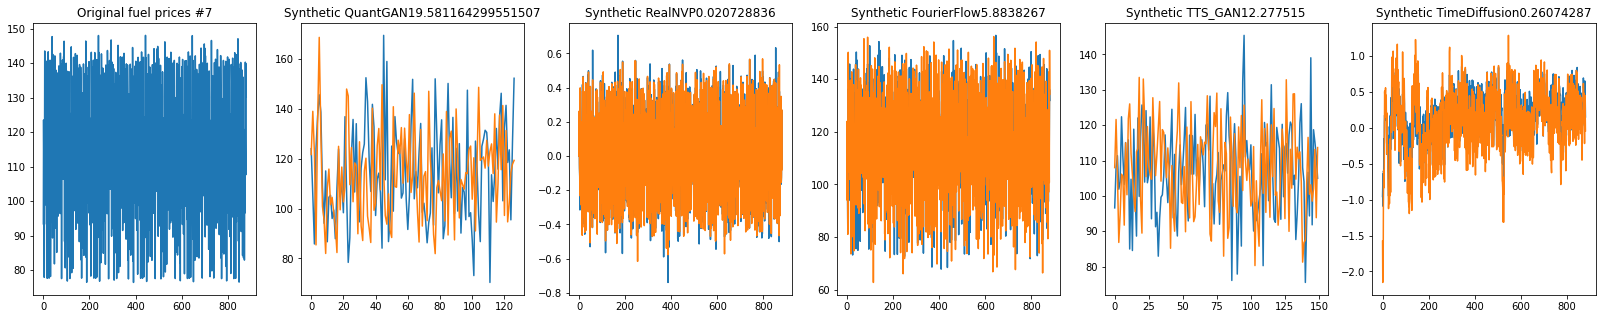

In [10]:
ts_iterator = get_fuel_prices_dataset(fp_dataset_dir)

for ts_index, time_series in enumerate(ts_iterator):
    fig, axs = plt.subplots(1, 6, figsize=(28, 5))
    axs[0].plot(time_series.values.flatten())
    axs[0].set_title(f"Original fuel prices #{ts_index}")
    # axs[0].get_xaxis().set_visible(False)
    # axs[0].get_yaxis().set_visible(False)
    for i, model_name in zip(range(1, 6), ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion")):
        synth_time_series = np.load(fp_dataset_dir / f"synthetic/{model_name}/selected{ts_index}.npy")
        axs[i].plot(synth_time_series[0].flatten())
        axs[i].plot(synth_time_series[1].flatten())
        axs[i].set_title(f"Synthetic {model_name}" + str(synth_time_series.std(axis=0).mean()))
        # axs[i].get_xaxis().set_visible(False)
        # axs[i].get_yaxis().set_visible(False)
plt.show()

# Synthetic similarity results

In [11]:
ds_lens = {"hsm": 100, "se": 10, "fp": 8, "ap": 50}

In [12]:
results = []
for model in ("QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
    for dataset_name in ("hsm", "se", "fp", "ap"):
        df = pd.read_csv(results_dir / f"synth_{dataset_name}_sim_{model}.csv")[:ds_lens[dataset_name]]
        results.append({"model": model, "dataset": dataset_name,
        "js_div": df["js_div"].mean(), "kstest_pass": (df["kstest_pval"] > 0.05).mean()})
synth_sim_results = pd.DataFrame(results)
synth_sim_results

,model,dataset,js_div,kstest_pass
0,QuantGAN,hsm,0.037181,0.140
1,QuantGAN,se,0.083084,0.000
2,QuantGAN,fp,0.037501,0.250
3,QuantGAN,ap,0.036218,0.100
4,TTS_GAN,hsm,0.033195,0.110
5,TTS_GAN,se,0.089325,0.000
6,TTS_GAN,fp,0.034081,0.125
7,TTS_GAN,ap,0.034563,0.240
8,RealNVP,hsm,0.038652,0.030
9,RealNVP,se,0.118025,0.000


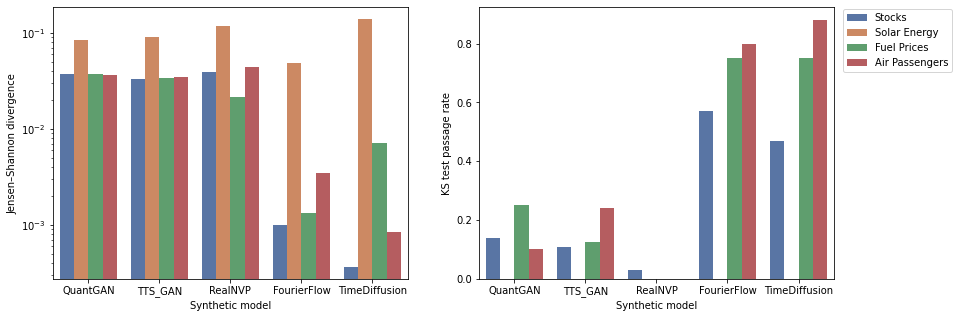

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric_name in enumerate(("js_div", "kstest_pass")):
    if metric_name == "kstest_pval":
        synth_sim_results
    sns.barplot(x=synth_sim_results["model"], y=synth_sim_results[metric_name], 
        hue=synth_sim_results["dataset"].replace({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}),\
             ax=axs[i], palette="deep")
axs[0].set_yscale("log")
axs[0].set_ylabel("Jensen–Shannon divergence")
axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.01, 1.01))
axs[1].set_ylabel("KS test passage rate")
for i in range(2): axs[i].set_xlabel("Synthetic model")
# axs[1].plot(axs[1].get_xbound(), [0.05] * 2, "k--")
plt.show()

In [14]:
dfs = {}
for res_type in ("real", "QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
    for model in ("LSTM", "TCN"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if res_type == "real":
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"{res_type}_{dataset_name}_{model}.csv")["test"]
            else:
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"synth_{res_type}_{dataset_name}_{model}.csv")["test"]
results = pd.DataFrame(dfs)
results

,real_LSTM_hsm,real_LSTM_se,real_LSTM_fp,real_LSTM_ap,real_TCN_hsm,real_TCN_se,real_TCN_fp,real_TCN_ap,QuantGAN_LSTM_hsm,QuantGAN_LSTM_se,...,FourierFlow_TCN_fp,FourierFlow_TCN_ap,TimeDiffusion_LSTM_hsm,TimeDiffusion_LSTM_se,TimeDiffusion_LSTM_fp,TimeDiffusion_LSTM_ap,TimeDiffusion_TCN_hsm,TimeDiffusion_TCN_se,TimeDiffusion_TCN_fp,TimeDiffusion_TCN_ap
0,0.352968,0.184991,0.202559,0.795698,0.260205,0.147378,0.166383,0.723236,0.882165,0.745066,...,0.202846,0.711581,0.834762,0.215989,0.213350,0.801214,0.276657,0.100244,0.192701,0.773793
1,0.168099,0.209926,0.143776,0.625052,0.152844,0.153060,0.156278,0.601431,0.871901,0.573585,...,0.168418,0.628996,0.154675,0.214732,0.193474,0.544858,0.115552,0.105198,0.170435,0.545326
2,1.425858,0.204776,0.268309,0.082674,0.939176,0.128122,0.208905,0.080697,0.912913,0.637555,...,0.216392,0.277708,1.770851,0.244076,0.251191,0.094730,1.011212,0.083384,0.197680,0.100139
3,0.139445,0.301617,0.164236,0.464227,0.068642,0.144217,0.138380,0.504273,0.858185,0.606333,...,0.173286,0.499886,0.083038,0.415893,0.205999,0.403026,0.068802,0.065921,0.169679,0.417928
4,0.283939,0.181014,0.229799,0.884233,0.137041,0.123609,0.233753,0.944198,0.928533,0.636180,...,0.244187,1.016143,0.257615,0.161803,0.234375,0.902008,0.154004,0.071665,0.215050,0.904928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.311294,NaN,NaN,NaN,0.252606,NaN,NaN,NaN,0.898519,NaN,...,NaN,NaN,0.338283,NaN,NaN,NaN,0.289453,NaN,NaN,NaN
96,0.228035,NaN,NaN,NaN,0.247496,NaN,NaN,NaN,0.961891,NaN,...,NaN,NaN,0.261745,NaN,NaN,NaN,0.228918,NaN,NaN,NaN
97,0.502270,NaN,NaN,NaN,0.060227,NaN,NaN,NaN,0.915655,NaN,...,NaN,NaN,0.202840,NaN,NaN,NaN,0.057294,NaN,NaN,NaN
98,1.980303,NaN,NaN,NaN,0.266872,NaN,NaN,NaN,0.895138,NaN,...,NaN,NaN,0.844601,NaN,NaN,NaN,0.309422,NaN,NaN,NaN


In [15]:
corrs = []
for model in ("LSTM", "TCN"):
    for res_type in ("QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            # correlation
            res = np.corrcoef([results[f"real_{model}_{dataset_name}"][:ds_lens[dataset_name]],
                results[f"{res_type}_{model}_{dataset_name}"][:ds_lens[dataset_name]]])[0][1]
            z = 0.5 * np.log((1 + res) / (1 - res))
            SE =  1 / (ds_lens[dataset_name] - 3) ** 0.5
            zl, zh = z - 1.96 * SE, z + 1.96 * SE
            lb, hb = ((np.e ** (2 * zl) - 1) / (np.e ** (2 * zl) + 1), (np.e ** (2 * zh) - 1) / (np.e ** (2 * zh) + 1))
            corrs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "correlation": res,\
                "low_bound": lb, "high_bound": hb})
corrs = pd.DataFrame(corrs)
corrs

,model,synth_model,dataset,correlation,low_bound,high_bound
0,LSTM,QuantGAN,hsm,0.012415,-0.184457,0.208328
1,LSTM,QuantGAN,se,-0.201272,-0.737451,0.490526
2,LSTM,QuantGAN,fp,-0.239242,-0.807746,0.559819
3,LSTM,QuantGAN,ap,-0.202230,-0.454972,0.080663
4,LSTM,TTS_GAN,hsm,-0.124267,-0.313047,0.073960
5,LSTM,TTS_GAN,se,0.417014,-0.288325,0.828985
6,LSTM,TTS_GAN,fp,-0.280908,-0.822729,0.528363
7,LSTM,TTS_GAN,ap,0.009035,-0.269996,0.286667
8,LSTM,RealNVP,hsm,0.739821,0.635791,0.817453
9,LSTM,RealNVP,se,0.518031,-0.165626,0.865398


In [16]:
corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()
corrs_agg

C:\Users\Владислав\AppData\Local\Temp/ipykernel_12944/2987291452.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()


,dataset,synth_model,correlation,low_bound,high_bound
0,ap,FourierFlow,0.875537,0.789785,0.927745
1,ap,QuantGAN,-0.239720,-0.485368,0.040951
2,ap,RealNVP,0.165381,-0.118422,0.424205
3,ap,TTS_GAN,-0.094063,-0.360386,0.186286
4,ap,TimeDiffusion,0.880248,0.798232,0.930366
5,fp,FourierFlow,0.997650,0.986520,0.999592
6,fp,QuantGAN,-0.354045,-0.844921,0.456006
7,fp,RealNVP,0.797682,0.212785,0.961743
8,fp,TTS_GAN,-0.279250,-0.822146,0.529657
9,fp,TimeDiffusion,0.995348,0.973464,0.999192


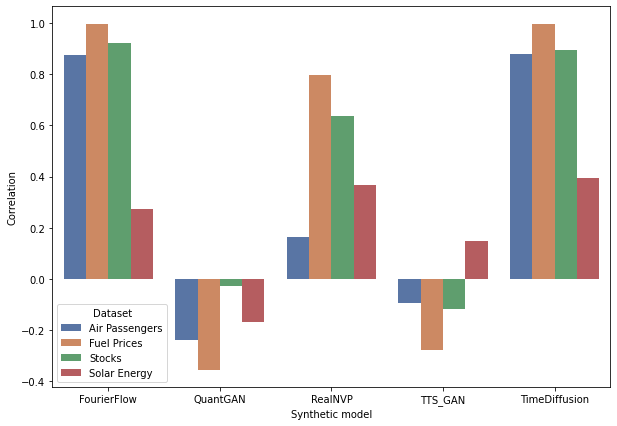

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x=corrs_agg["synth_model"], y=corrs_agg["correlation"],\
    hue=corrs_agg.rename(columns={"dataset": "Dataset"})["Dataset"]\
        .replace({"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}), \
        ax=ax, palette="deep")
ax.set_ylabel("Correlation")
ax.set_xlabel("Synthetic model")
plt.show()

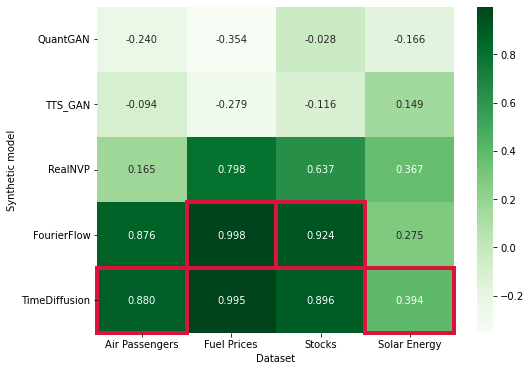

In [18]:
data_to_plot = corrs_agg.pivot_table(index="synth_model", columns="dataset", values="correlation", aggfunc=np.mean).sort_values("ap")\
        .rename(columns={"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"})

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data_to_plot, annot=True, fmt=".3f", cmap="Greens", ax=ax)
for i, col in enumerate(data_to_plot.columns):
        ind = np.argmax(data_to_plot[col].values)
        ax.add_patch(Rectangle((i, ind), 1, 1, fill=False, edgecolor='crimson', lw=4, clip_on=False))
ax.set_ylabel("Synthetic model")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel("Dataset")
plt.show()

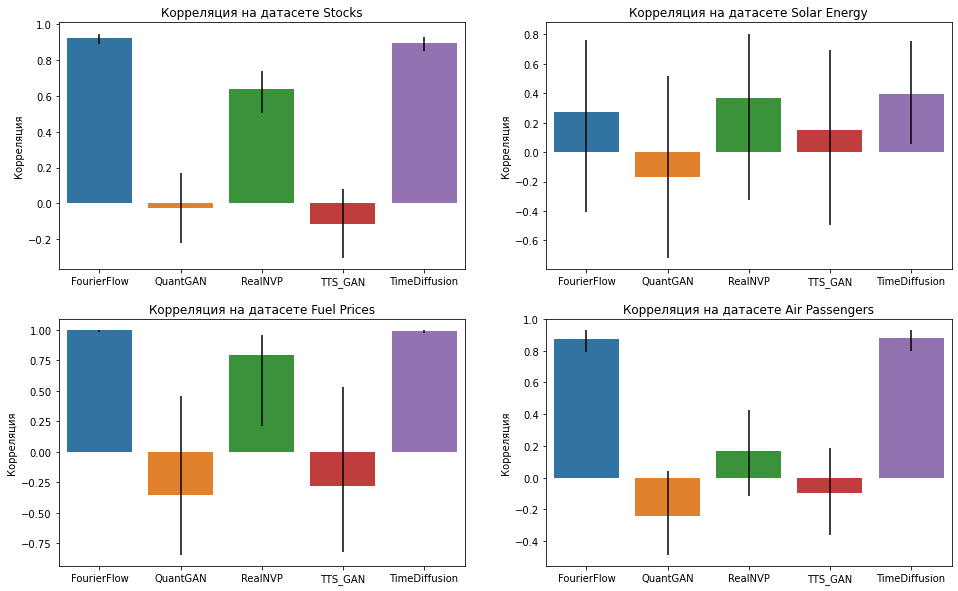

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i, dsname in enumerate(("hsm", "se", "fp", "ap")):
    loc_data = corrs_agg[corrs_agg.dataset == dsname]
    sns.barplot(data=loc_data, x="synth_model", y="correlation",\
        yerr=(loc_data["correlation"] - loc_data["low_bound"], loc_data["high_bound"] - loc_data["correlation"]), ax=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title("Корреляция на датасете " + {"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}[dsname])
    axs[i // 2][i % 2].set_xlabel("")
    axs[i // 2][i % 2].set_ylabel("Корреляция")

Deviation

In [20]:
devs = []  # deviation
for model in ("LSTM", "TCN"):
    for res_type in ("QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            # deviation
            dev = np.mean(np.abs(results[f"{res_type}_{model}_{dataset_name}"][:ds_lens[dataset_name]] /\
                results[f"real_{model}_{dataset_name}"][:ds_lens[dataset_name]] - 1)) * 100
            devs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "deviation": dev,})
devs = pd.DataFrame(devs)
devs

,model,synth_model,dataset,deviation
0,LSTM,QuantGAN,hsm,334.009467
1,LSTM,QuantGAN,se,221.782044
2,LSTM,QuantGAN,fp,268.422156
3,LSTM,QuantGAN,ap,51.244294
4,LSTM,TTS_GAN,hsm,378.462622
5,LSTM,TTS_GAN,se,1246.262020
6,LSTM,TTS_GAN,fp,265.885110
7,LSTM,TTS_GAN,ap,55.394856
8,LSTM,RealNVP,hsm,53.855794
9,LSTM,RealNVP,se,62.479944


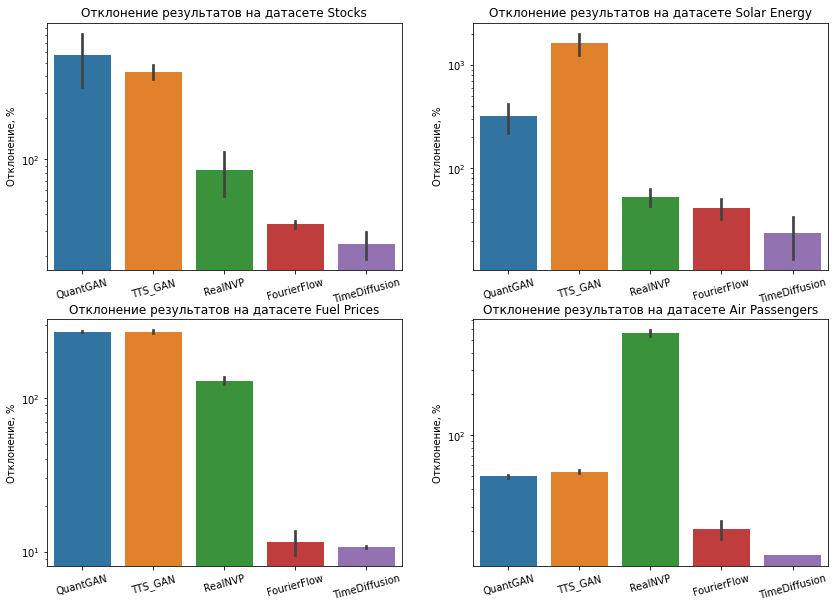

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
ds_name_extension = {"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}
for i, dataset in enumerate(("hsm", "se", "fp", "ap")):
    sns.barplot(data=devs[devs.dataset == dataset], x="synth_model", y="deviation", ax=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title(f"Отклонение результатов на датасете {ds_name_extension[dataset]}")
    axs[i // 2][i % 2].set_ylabel("Отклонение, %")
    axs[i // 2][i % 2].set_xlabel("")
    axs[i // 2][i % 2].set_xticklabels(axs[i // 2][i % 2].get_xticklabels(), rotation=15)
    axs[i // 2][i % 2].set_yscale("log")

Train / test split example

In [22]:
iterator = get_dataset_iterator("hsm", hsm_dataset_dir)
next(iterator)
ts = next(iterator)

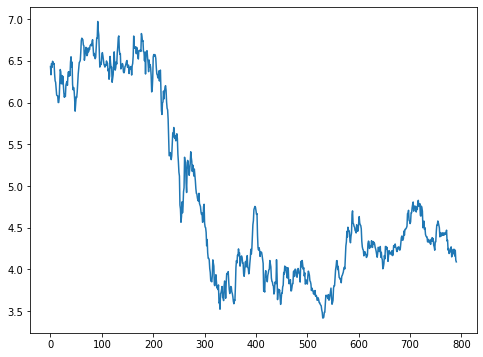

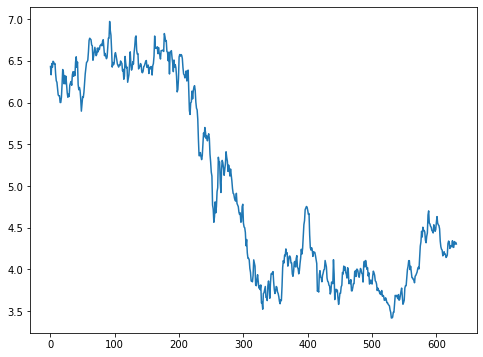

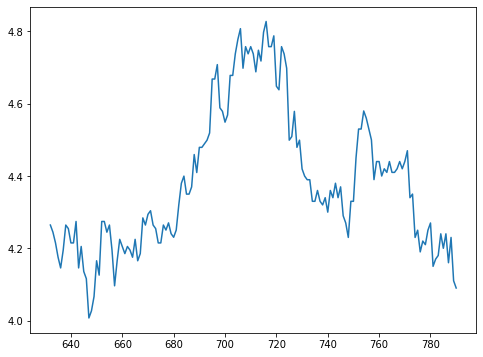

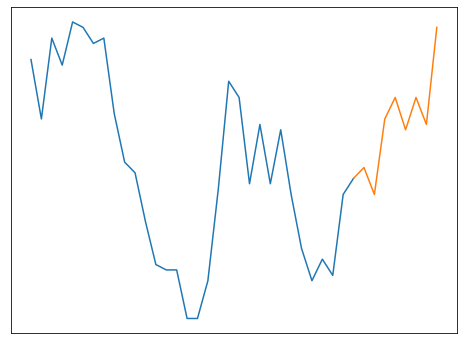

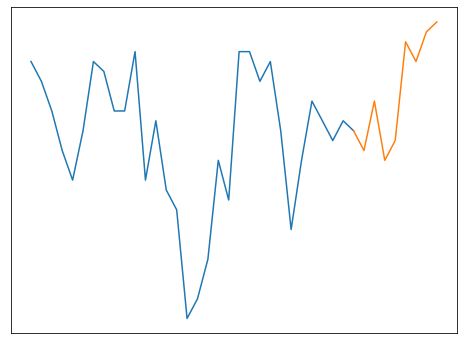

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
ts.plot(ax=ax)
ax.get_legend().remove()
plt.show()

edge = int(0.8 * len(ts))
fig, ax = plt.subplots(figsize=(8, 6))
ts[:edge].plot(ax=ax)
ax.get_legend().remove()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ts[edge:].plot(ax=ax)
ax.get_legend().remove()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(ts[:32], label="lags")
ax.plot(ts[31: 40], label="horizon")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(ts[edge: edge + 32], label="lags")
ax.plot(ts[edge + 31: edge + 40], label="horizon")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()